![](https://i.imgur.com/JsMvGnP.png)

# Projeto - Classificação

## 1. Considerações iniciais

Neste notebook iremos praticar a construção de um modelo de Machine Learning. Na atividade, iremos utilizar um algoritmo para realizar um processo de classificação. 

Como o foco da atividade será percorrer o fluxo do Aprendizado de Máquina por inteiro (ou o máximo dele), evitaremos, propositalmente, adentrar em algoritmos e explicações mais complexas.


### 1.1. O Problema de Negócio

A _churn rate_ (taxa de rotatividade ou cancelamento) é a porcentagem de assinantes que interrompem suas assinaturas de um serviço dentro de um determinado período de tempo. Para uma empresa expandir sua clientela, sua taxa de crescimento, medida pelo número de novos clientes, deve exceder sua taxa de cancelamento (_churn rate_).

Portanto, neste projeto, um banco deseja que você construa um modelo de Machine Learning que possa prever a probabilidade de seus clientes atuais fecharem suas contas em um futuro próximo e, portanto, calcular sua _churn rate_.

Esse é um problema de classificação no qual você classifica se um cliente irá sair (y=1) ou permanecer (y=0) com base diversos atributos.

### 1.2. Descrição do dados

Os dados necessários podem ser encontrados no [repositório da atividade](https://github.com/awarischool/br-classification-project). No arquivo *Churn_Modelling.csv* você encontrará:
- **RowNumber**: id do registro/linha.
- **CustomerId**: identificador único do cliente.
- **Surname**: sobrenome do cliente.
- **CreditScore**: pontuação de crédito do cliente.
- **Geography**: país de origem do cliente.
- **Gender**: sexo do cliente.
- **Age**: idade do cliente.
- **Tenure**: número de anos em que o cliente está com o banco.
- **Balance**: saldo bancário.
- **NumOfProducts**: número de produtos que o cliente utiliza.
- **HasCrCard**: indica se o cliente tem (1) ou não tem (0) cartão de crédito.
- **IsActiveMember**: indica se o cliente é (1) ou não é (0) ativo no banco.
- **EstimatedSalary**: salário estimado em dólares.
- **Exited**: indica se o cliente encerrou (1) a conta no banco ou se o cliente foi retido (0).


### 1.3 Métricas de Avaliação

Avalie seu modelo utilizando as métricas Acurácia e AUC (area under the ROC) estudadas nos módulos anteriores.

Trabalhe até conseguir uma acurácia acima e 85%.

## 2. Etapas do Projeto

Neste projeto você poderá seguir o fluxo que preferir, mas como sugestão pode seguir as seguintes etapas:
1. Análise exploratória 
2. Preparação e limpeza dos dados
3. Seleção de atributos
4. Construção do modelo
5. Avaliação do modelo
6. Otimização do modelo

Lembrando que esses passos, provavelmente, serão executados várias vezes até se obter um resultado satisfatório.

Sugestões de modelos:
* Logistic Regression Classification
* K-Nearest Neighbour (KNN) Classification
* Support Vector Machine (SVM) Classification
* Naive Bayes Classification
* Decision Tree Classification
* Random Forest Classification

Em caso de dúvidas, não esqueça de conversar com seu mentor.

## 3. Desenvolvimento do Projeto
*Adicione células você precisar para cada etapa*

In [30]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
sns.set_style('darkgrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

#XGBoost

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

In [2]:
#import dataset
csv_churn = 'https://raw.githubusercontent.com/armandocesar/br-classification-project/master/Churn_Modelling.csv'

churn = pd.read_csv(csv_churn)

### 3.1 Análise exploratória

In [5]:
churn.isna().value_counts()

RowNumber  CustomerId  Surname  CreditScore  Geography  Gender  Age    Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited
False      False       False    False        False      False   False  False   False    False          False      False           False            False     10000
dtype: int64

In [12]:
def split_dataframe(dataframe):
  cat_dataframe = pd.DataFrame(dataframe.iloc[:,0:2])
  cont_dataframe = pd.DataFrame(dataframe.iloc[:,0:2])
  col = list(dataframe.columns)
  col.pop(0)
  col.pop(0)
  for c in col:
    if dataframe[c].dtypes == 'object':
      cat_dataframe = pd.concat([cat_dataframe, dataframe[c]], axis = 1)
    elif dataframe[c].isin([0,1,'Nan']).all():
        cat_dataframe = pd.concat([cat_dataframe, dataframe[c]], axis = 1)
    else:
      cont_dataframe = pd.concat([cont_dataframe, dataframe[c]], axis = 1)
  cat = cat_dataframe
  cont = cont_dataframe
  cont['Exited'] = dataframe.iloc[:,-1]
  return cat, cont

In [13]:
cat_churn, cont_churn = split_dataframe(churn)

In [14]:
cat_churn

,RowNumber,CustomerId,Surname,Geography,Gender,HasCrCard,IsActiveMember,Exited
0,1,15634602,Hargrave,France,Female,1,1,1
1,2,15647311,Hill,Spain,Female,0,1,0
2,3,15619304,Onio,France,Female,1,0,1
3,4,15701354,Boni,France,Female,0,0,0
4,5,15737888,Mitchell,Spain,Female,1,1,0
...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,France,Male,1,0,0
9996,9997,15569892,Johnstone,France,Male,1,1,0
9997,9998,15584532,Liu,France,Female,0,1,1
9998,9999,15682355,Sabbatini,Germany,Male,1,0,1


In [15]:
cont_churn

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited
0,1,15634602,619,42,2,0.00,1,101348.88,1
1,2,15647311,608,41,1,83807.86,1,112542.58,0
2,3,15619304,502,42,8,159660.80,3,113931.57,1
3,4,15701354,699,39,1,0.00,2,93826.63,0
4,5,15737888,850,43,2,125510.82,1,79084.10,0
...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,39,5,0.00,2,96270.64,0
9996,9997,15569892,516,35,10,57369.61,1,101699.77,0
9997,9998,15584532,709,36,7,0.00,1,42085.58,1
9998,9999,15682355,772,42,3,75075.31,2,92888.52,1


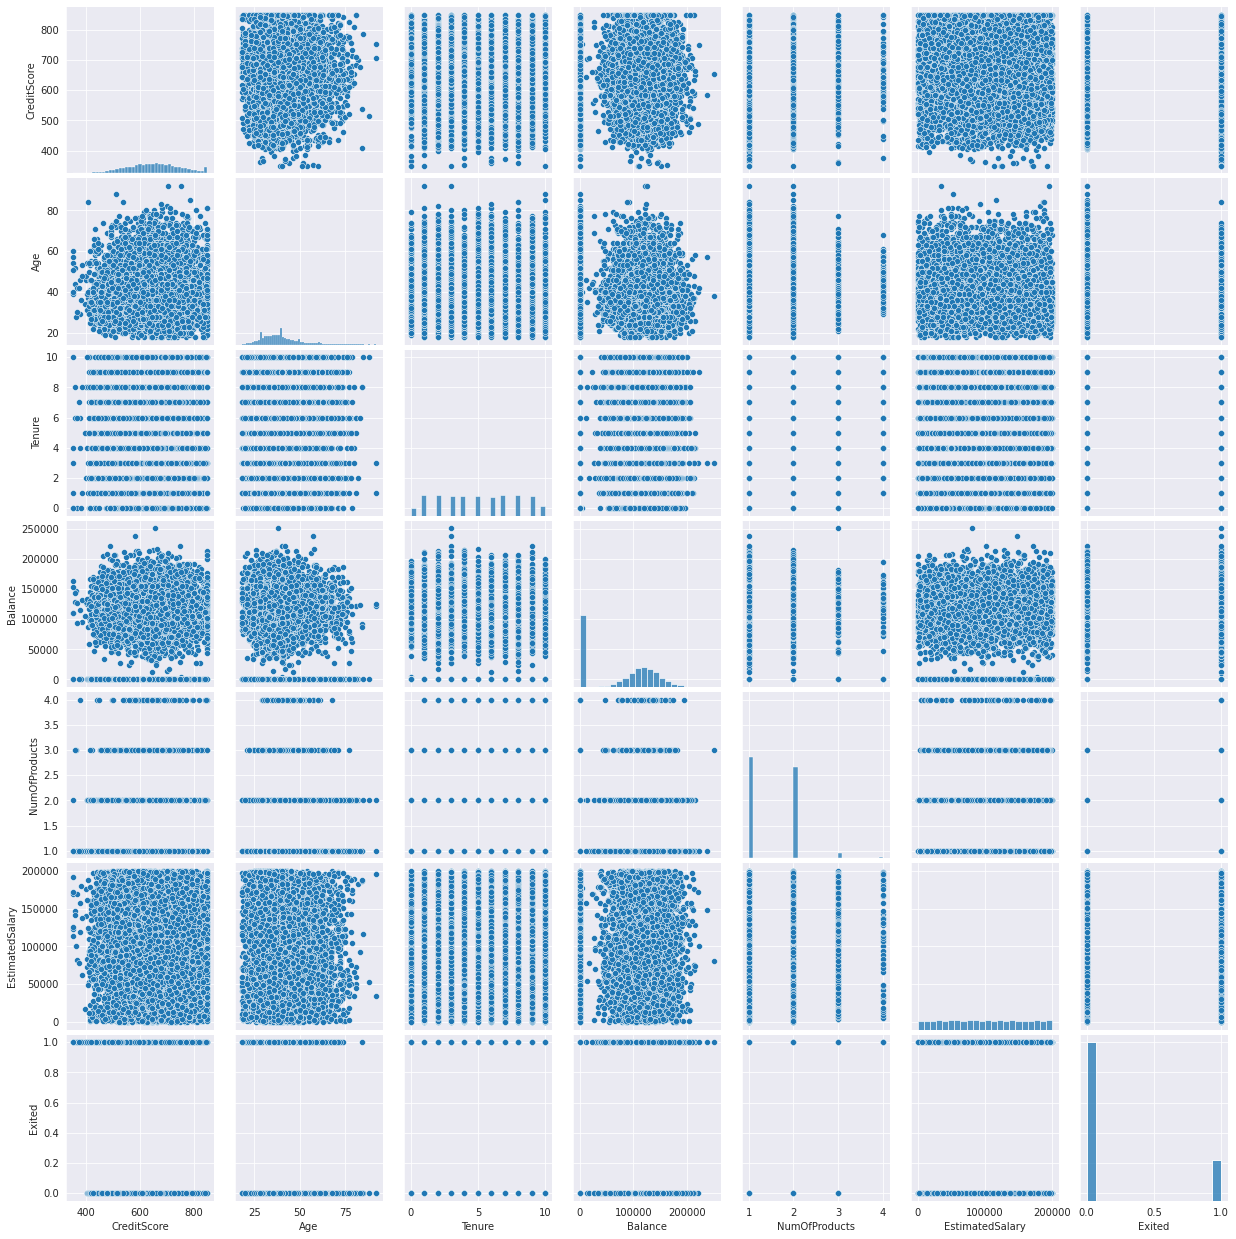

In [16]:
sns.pairplot(cont_churn.iloc[:,2:])

### 3.2 Preparação e limpeza dos dados

In [45]:
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [46]:
#Drop Surname column
churn.drop('Surname', axis=1, inplace=True)

In [47]:
#Encode dataframe
churn_en = pd.get_dummies(churn)

In [69]:
col = list(churn_en.columns)
col.remove('Exited')

In [70]:
col.append('Exited')

In [72]:
churn_en = churn_en[col]

### 3.3 Seleção de atributos

In [74]:
correlation = churn_en.iloc[:,2:].corr()

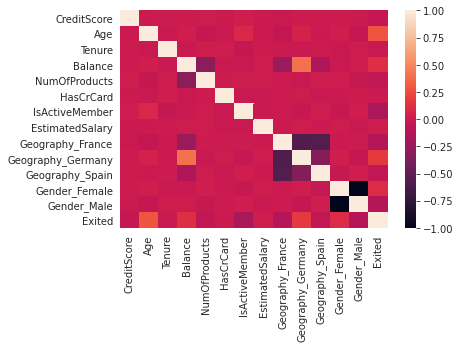

In [75]:
# seu código
sns.heatmap(correlation)

### 3.4 Construção do modelo

In [76]:
#Dataframe split

x_train, x_test, y_train, y_test = train_test_split(churn_en.iloc[:,2:-1], churn_en.iloc[:,-1])


In [88]:
clf = lgb.LGBMClassifier(
              learning_rate = .05, #so called `eta` value
              max_depth = 6,
              min_child_weight = 4,
              subsample =  0.7,
              colsample_bytree = 0.7,
              n_estimators= 500,
)

clf.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.05, max_depth=6,
               min_child_samples=20, min_child_weight=4, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

Evaluation of the results using the ROC AUC curve

In [89]:
y_predict_lgbm = clf.predict_proba(x_test)[:,1]


### 3.5 Avaliação do modelo

In [85]:
# seu código
#Plot ROC AUC Curve
def plot_roc(y_test, y_predict):
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    plt.figure(figsize=(10,8))
    plt.title("ROC curve")
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1],'r--')
    plt.legend(loc="lower right")

0.857097902097902


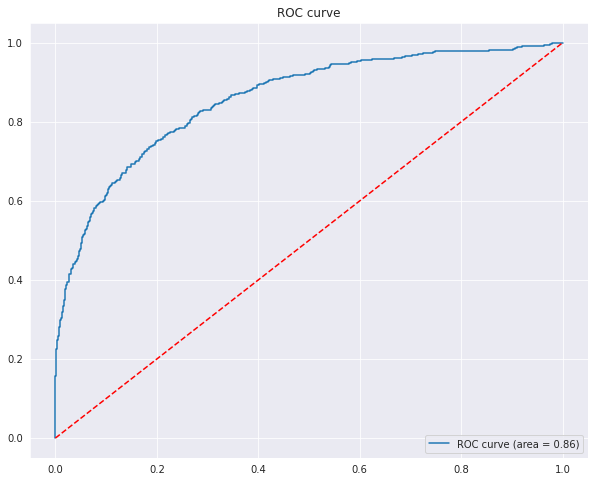

In [90]:
# seu código
plot_roc(y_test, y_predict_lgbm)

### 3.4 Otimização do modelo

In [91]:
gridParams = {
    'learning_rate': [0.05, 0.1],
    'num_leaves': [10, 50, 90, 200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [-1],
    'random_state' : [16], 
    'colsample_bytree' : [0.5,0.7, 0.9],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'n_estimators': [100, 250,500],
    'metric':['auc']
    }

In [92]:
g_clf = lgb.LGBMClassifier()

In [93]:
grid = RandomizedSearchCV(g_clf, gridParams, cv=4, verbose=2, n_jobs=-1)
grid.fit(x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   20.9s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                        'colsample_bytree': [0.5, 0.7, 0.9],
                                        'learnin

In [94]:
grid.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 10,
 'min_split_gain': 0.01,
 'n_estimators': 100,
 'num_leaves': 10,
 'objective': 'binary',
 'random_state': 16,
 'subsample': 0.5}

In [95]:
y_pred = grid.predict_proba(x_test)[:,1]

0.8669847513597515


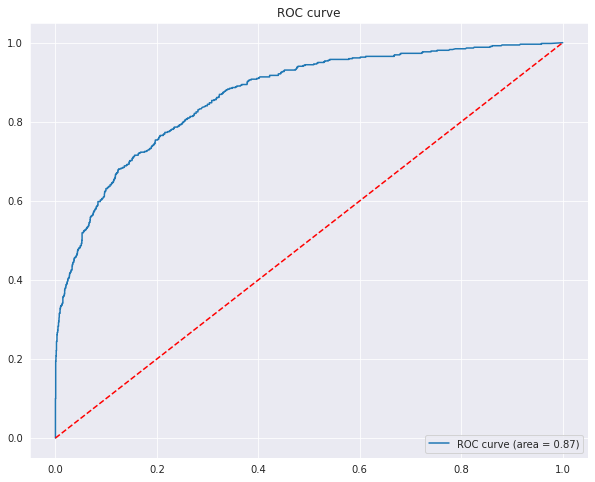

In [96]:
# seu código

plot_roc(y_test, y_pred)

In [ ]:
# seu código

## 4. Conclusão
O fluxo de trabalho de Aprendizado de Máquina não termina após a avaliação de performance do modelo escolhido. Na verdade, esta seria somente a primeira iteração de um processo que pode ter dezenas de tentativas.

Encorajamos você a repetir novamente o processo descrito neste notebook. Contudo, explorando novas possibilidades para verificar a melhora/piora da performance do seu modelo. 

Você pode, por exemplo, remover variáveis/atributos menos importantes, normalizar variáveis importantes e escolher outros algoritmos de aprendizagem supervisionada. O Aprendizado de Máquina é uma área interessante justamente por causa disto. Você testa, você erra, você recomeça.